In [1]:
# Built based on Agentic Document Extraction – Python Library git library (Lecture 8 Week 14 Readings: Video: Andrew Ng Explores The Rise Of AI Agents And Agentic Reasoning)

# Part 1: Configuration & Imports
# Set environment variables BEFORE importing agentic_doc (API key generated on https://va.landing.ai/settings/api-key page on 22/04/2025)
import os

os.environ['VISION_AGENT_API_KEY'] = 'cTBodDlyaGgyOGlxdGFya2Y4OWdiOmg5dm54aUhoVWdzQk1wc1IwQkVwYjBGcnp3Mkh0NUF6'
os.environ['BATCH_SIZE']          = os.getenv('BATCH_SIZE', '2')
os.environ['MAX_WORKERS']         = os.getenv('MAX_WORKERS', '4')
os.environ['MAX_RETRIES']         = os.getenv('MAX_RETRIES', '80')
os.environ['MAX_RETRY_WAIT_TIME'] = os.getenv('MAX_RETRY_WAIT_TIME', '30')
os.environ['RETRY_LOGGING_STYLE'] = os.getenv('RETRY_LOGGING_STYLE', 'log_msg')

# 1. Standard library imports
import logging
import re
import sys
from datetime import datetime
import numpy as np                 
import pandas as pd                
import matplotlib.pyplot as plt    
from tqdm.auto import tqdm         

from agentic_doc.parse import parse_documents
from transformers import pipeline
import spacy                        # for sentence splitting (if using spaCy)


logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)

# Environment check logs
logging.info("VISION_AGENT_API_KEY present: %s", bool(os.getenv('VISION_AGENT_API_KEY')))
logging.info("BATCH_SIZE: %s", os.getenv('BATCH_SIZE'))


2025-05-01 17:09:31 [info   ] Settings loaded: {
  "vision_agent_api_key": "cTBod[REDACTED]",
  "batch_size": 2,
  "max_workers": 4,
  "max_retries": 80,
  "max_retry_wait_time": 30,
  "retry_logging_style": "log_msg",
  "pdf_to_image_dpi": 96
} [agentic_doc.config] (config.py:80)
VISION_AGENT_API_KEY present: True (1395369554.py:36)
BATCH_SIZE: 2 (1395369554.py:37)


In [2]:
# Part 2: Check if the PDFs are in the correct folder 

from typing import List

def discover_pdfs(
    base_dir: str,
    subfolders: List[str],
    extensions: List[str] = [".pdf"]
) -> List[str]:

    pdf_paths: List[str] = []

    for sub in subfolders:
        dir_path = os.path.join(base_dir, sub)
        if not os.path.isdir(dir_path):
            logging.warning(f"Folder not found, skipping: {dir_path}")
            continue

        for fname in os.listdir(dir_path):
            if any(fname.lower().endswith(ext) for ext in extensions):
                full_path = os.path.join(dir_path, fname)
                pdf_paths.append(full_path)

    pdf_paths.sort()
    logging.info(f"Found {len(pdf_paths)} PDF(s) in {base_dir}/{subfolders}")
    return pdf_paths

# Folders were named based on the product type 
BASE_DIR   = os.getenv("DATA_DIR", "data")
SUBFOLDERS = ["K2", "K3", "K4", "K5", "K7"]

all_pdf_files = discover_pdfs(BASE_DIR, SUBFOLDERS)
if not all_pdf_files:
    logging.error("No PDF files found in any of the subfolders.")
else:
    logging.info(f"First PDF found: {all_pdf_files[0]}")


Found 68 PDF(s) in data/['K2', 'K3', 'K4', 'K5', 'K7'] (3226644089.py:25)
First PDF found: data\K2\K 2 Battery Set _ Kärcher.pdf (3226644089.py:36)


Previewing page 0 of data\K2\K 2 Battery Set _ Kärcher.pdf (3496547632.py:11)


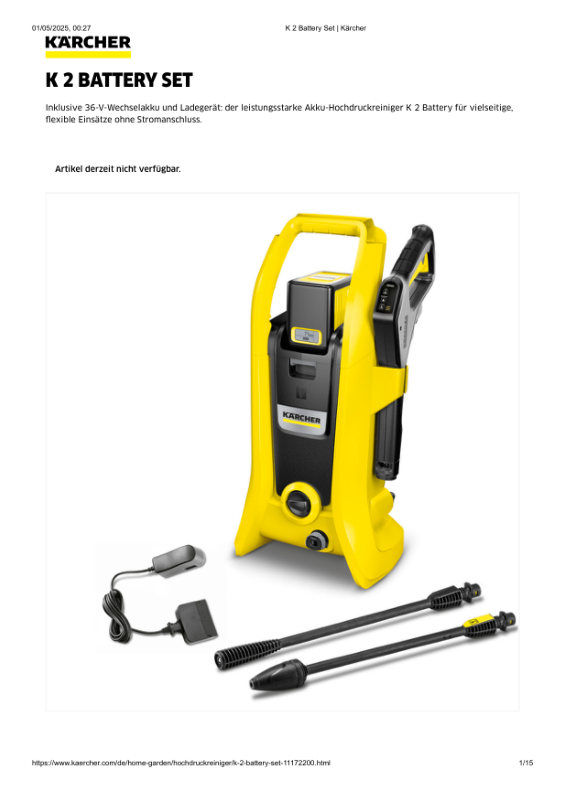

In [3]:
# Part 3: PDF Preview 

import fitz  # PyMuPDF (https://pymupdf.readthedocs.io/en/latest/) - used it in another course to import PDFs

def preview_pdf(
    pdf_path: str,
    page_number: int = 0,
    figsize: tuple[int, int] = (13, 10)
) -> None:

    logging.info(f"Previewing page {page_number} of {pdf_path}")
    try:
        doc = fitz.open(pdf_path)
        page = doc.load_page(page_number)
        pix = page.get_pixmap(alpha=False)
        img = np.frombuffer(pix.samples, dtype=np.uint8).reshape(
            pix.height, pix.width, pix.n
        )
        plt.figure(figsize=figsize)
        plt.imshow(img)
        plt.axis("off")
        plt.show()
    except Exception as e:
        logging.error(f"Failed to preview PDF {pdf_path}: {e}")

# Example usage:
if all_pdf_files:
    preview_pdf(all_pdf_files[0])


In [4]:
# Part 4: Raw Text Extraction 

import fitz
from typing import List, Dict

def clean_text(text: str) -> str:
    cleaned = re.sub(r'\s+', ' ', text)
    return cleaned.strip()

def extract_text_stats(pdf_path: str) -> List[Dict]:

    logging.info(f"Extracting text from {pdf_path}")
    doc = fitz.open(pdf_path)
    pages: List[Dict] = []

    for page_number, page in enumerate(tqdm(doc, desc="Reading pages")):
        raw = page.get_text()
        text = clean_text(raw)
        pages.append({
            "page_number": page_number,
            "page_char_count": len(text),
            "page_word_count": len(text.split()),
            "page_sentence_count": len(text.split(". ")),
            "page_token_est": len(text) / 4,
            "text": text
        })

    return pages

if all_pdf_files:
    first_pdf = all_pdf_files[0]
    page_stats = extract_text_stats(first_pdf)
    print(page_stats[:2]) 

Extracting text from data\K2\K 2 Battery Set _ Kärcher.pdf (441645686.py:12)


Reading pages:   0%|          | 0/7 [00:00<?, ?it/s]

[{'page_number': 0, 'page_char_count': 338, 'page_word_count': 34, 'page_sentence_count': 3, 'page_token_est': 84.5, 'text': 'K 2 BATTERY SET Inklusive 36-V-Wechselakku und Ladegerät: der leistungsstarke Akku-Hochdruckreiniger K 2 Battery für vielseitige, flexible Einsätze ohne Stromanschluss. Artikel derzeit nicht verfügbar. 01/05/2025, 00:27 K 2 Battery Set | Kärcher https://www.kaercher.com/de/home-garden/hochdruckreiniger/k-2-battery-set-11172200.html 1/15'}, {'page_number': 1, 'page_char_count': 1571, 'page_word_count': 198, 'page_sentence_count': 12, 'page_token_est': 392.75, 'text': 'MERKMALE UND VORTEILE Bestellnummer: 1.117-220.0 Händlersuche: 4.0 (30) Jetzt Produkt bewerten Produkt vergleichen Benötigen Sie Hilfe? Hotline: +49 7195 903 0 Dieses Produkt enthält einen Akku. Für Akku-Geräte gelten besondere Bestimmungen bei Versand und Rücksendung. Hier finden Sie unsere Gefahrguthinweise. Ort oder PLZ Keinen Stromanschluss zur Verfügung? Kein Problem! Mit den neuen Akkugeräten 

Extracting text from data\K2\K 2 Battery Set _ Kärcher.pdf (441645686.py:12)


Reading pages:   0%|          | 0/7 [00:00<?, ?it/s]

Page-level statistics (head):
   page_number  page_char_count  page_word_count  page_sentence_count  \
0            0              338               34                    3   
1            1             1571              198                   12   
2            2              390               39                    4   
3            3              382               36                    3   
4            4              640               68                    6   

   page_token_est                                               text  
0           84.50  K 2 BATTERY SET Inklusive 36-V-Wechselakku und...  
1          392.75  MERKMALE UND VORTEILE Bestellnummer: 1.117-220...  
2           97.50  36 V Kärcher Battery Power-Wechselakku Real Ti...  
3           95.50  Hochdruckpistole mit Druckstufenanzeige Versch...  
4          160.00  Wasseransaugung Kompatibel mit dem Kärcher Ans...   (3086373330.py:15)
Page-level statistics (describe):
       page_number  page_char_count  page_word_count

Computing sentence counts:   0%|          | 0/7 [00:00<?, ?it/s]

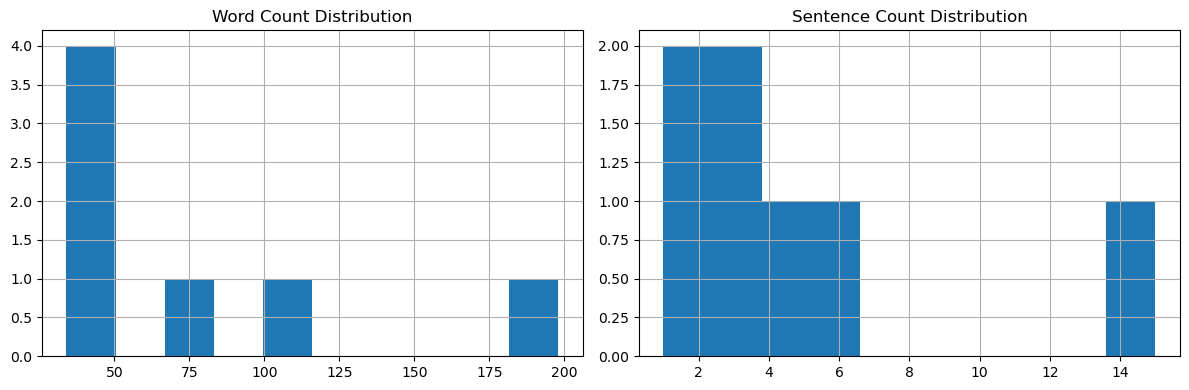

In [5]:
# Part 5: Exploratory Data Analysis (EDA)
import random
import pandas as pd

from spacy.lang.de import German # spaCy model for German because the PDFs are in German
import logging

def explore_text_stats(
    page_stats: List[Dict],
    sample_k: int = 3
) -> pd.DataFrame:

    # 1) Build DataFrame and display basic stats
    df = pd.DataFrame(page_stats)
    logging.info("Page-level statistics (head):\n%s", df.head())
    logging.info("Page-level statistics (describe):\n%s", df.describe().round(2))

    # 2) Sample raw text snippets
    k = min(sample_k, len(page_stats))
    logging.info("Sampling %d pages for snippet inspection:", k)
    for item in random.sample(page_stats, k):
        snippet = item["text"][:200].replace("\n", " ")
        logging.info("Page %d snippet: %s…", item["page_number"], snippet)

    # 3) Compute true sentence counts
    nlp = German()
    nlp.add_pipe("sentencizer")
    sentence_counts = []
    for item in tqdm(page_stats, desc="Computing sentence counts"):
        doc = nlp(item["text"])
        sentence_counts.append(len(list(doc.sents)))
    df["sentence_count"] = sentence_counts

    # 4) Plot distributions
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    df["page_word_count"].hist(ax=axes[0])
    axes[0].set_title("Word Count Distribution")
    df["sentence_count"].hist(ax=axes[1])
    axes[1].set_title("Sentence Count Distribution")
    plt.tight_layout()
    plt.show()

    return df

if all_pdf_files:
    first_pdf = all_pdf_files[0]
    stats = extract_text_stats(first_pdf)
    pages_df = explore_text_stats(stats, sample_k=3)


In [6]:
# Part 6: Document Parsing & Markdown Export using agentic_doc

import os
import logging
from tqdm.auto import tqdm
from agentic_doc.parse import parse_documents

def parse_pdfs_to_markdown(
    pdf_paths: list[str],
    output_dir: str,
    parse_kwargs: dict = None
) -> None:
    os.makedirs(output_dir, exist_ok=True)
    parse_kwargs = parse_kwargs or {}

    logging.info(f"Parsing/exporting up to {len(pdf_paths)} PDFs…")
    for pdf_path in tqdm(pdf_paths, desc="PDFs"):
        pdf_name = os.path.splitext(os.path.basename(pdf_path))[0]
        out_md = os.path.join(output_dir, f"{pdf_name}.md")

        # Skip if already done
        if os.path.exists(out_md):
            logging.info(f"Skipping '{pdf_name}'—'{out_md}' already exists")
            continue

        logging.info(f"Parsing '{pdf_path}'")
        try:
            parsed_doc = parse_documents([pdf_path], **parse_kwargs)[0]
            logging.info(f"Writing markdown to '{out_md}'")
            with open(out_md, "w", encoding="utf-8") as f_out:
                f_out.write(parsed_doc.markdown)
        except Exception as e:
            logging.error(f"Failed on '{pdf_path}': {e}")

# Preserve your original default folder name:
PARSED_MD_DIR = os.getenv("PARSED_MD_DIR", "parsed_markdown")
parse_pdfs_to_markdown(
    all_pdf_files,
    PARSED_MD_DIR,
)


Parsing/exporting up to 68 PDFs… (1326231452.py:16)


PDFs:   0%|          | 0/68 [00:00<?, ?it/s]

Skipping 'K 2 Battery Set _ Kärcher'—'parsed_markdown\K 2 Battery Set _ Kärcher.md' already exists (1326231452.py:23)
Skipping 'K 2 Battery _ Kärcher'—'parsed_markdown\K 2 Battery _ Kärcher.md' already exists (1326231452.py:23)
Skipping 'K 2 Classic _ Kärcher'—'parsed_markdown\K 2 Classic _ Kärcher.md' already exists (1326231452.py:23)
Skipping 'K 2 Horizontal VPS _ Kärcher'—'parsed_markdown\K 2 Horizontal VPS _ Kärcher.md' already exists (1326231452.py:23)
Skipping 'K 2 Power Control Car & Home _ Kärcher'—'parsed_markdown\K 2 Power Control Car & Home _ Kärcher.md' already exists (1326231452.py:23)
Skipping 'K 2 Power Control Home _ Kärcher'—'parsed_markdown\K 2 Power Control Home _ Kärcher.md' already exists (1326231452.py:23)
Skipping 'K 2 Power Control _ Kärcher'—'parsed_markdown\K 2 Power Control _ Kärcher.md' already exists (1326231452.py:23)
Skipping 'K 2 Premium FJ Home _ Kärcher'—'parsed_markdown\K 2 Premium FJ Home _ Kärcher.md' already exists (1326231452.py:23)
Skipping 'K 2 


Parsing documents:   0%|          | 0/1 [00:00<?, ?it/s]

2025-05-01 17:09:42 [info   ] Splitting PDF: 'data\K7\K 7 WCM FJ _ Kärcher.pdf' into 2 parts under 'C:\Users\ALEXAN~1\AppData\Local\Temp\tmp7l8bulbw' [agentic_doc.utils] (utils.py:202)
2025-05-01 17:09:42 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmp7l8bulbw\K 7 WCM FJ _ Kärcher_1.pdf [agentic_doc.utils] (utils.py:218)
2025-05-01 17:09:42 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmp7l8bulbw\K 7 WCM FJ _ Kärcher_2.pdf [agentic_doc.utils] (utils.py:218)
2025-05-01 17:09:42 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmp7l8bulbw\K 7 WCM FJ _ Kärcher_3.pdf [agentic_doc.utils] (utils.py:218)
2025-05-01 17:09:42 [info   ] Start parsing document part: 'File name: K 7 WCM FJ _ Kärcher_1.pdf	Page: [0:1]'

 [agentic_doc.parse

Parsing document parts from 'K 7 WCM FJ _ Kärcher.pdf':   0%|          | 0/3 [00:00<?, ?it/s]

] (parse.py:233)
2025-05-01 17:09:42 [info   ] Start parsing document part: 'File name: K 7 WCM FJ _ Kärcher_2.pdf	Page: [2:3]' [agentic_doc.parse] (parse.py:233)
2025-05-01 17:09:42 [info   ] Start parsing document part: 'File name: K 7 WCM FJ _ Kärcher_3.pdf	Page: [4:4]' [agentic_doc.parse] (parse.py:233)
HTTP Request: POST https://api.va.landing.ai/v1/tools/agentic-document-analysis "HTTP/1.1 200 OK" (_client.py:1025)
2025-05-01 17:11:28 [info   ] Time taken to successfully parse a document chunk: 106.37 seconds [agentic_doc.parse] (parse.py:298)
2025-05-01 17:11:28 [info   ] Successfully parsed document part: 'File name: K 7 WCM FJ _ Kärcher_1.pdf	Page: [0:1]' [agentic_doc.parse] (parse.py:235)




Parsing document parts from 'K 7 WCM FJ _ Kärcher.pdf':  33%|███▎      | 1/3 [01:46<03:32, 106.39s/it]

HTTP Request: POST https://api.va.landing.ai/v1/tools/agentic-document-analysis "HTTP/1.1 200 OK" (_client.py:1025)
2025-05-01 17:11:49 [info   ] Time taken to successfully parse a document chunk: 127.32 seconds [agentic_doc.parse] (parse.py:298)
2025-05-01 17:11:49 [info   ] Successfully parsed document part: 'File name: K 7 WCM FJ _ Kärcher_2.pdf	Page: [2:3]' [agentic_doc.parse] (parse.py:235)




Parsing document parts from 'K 7 WCM FJ _ Kärcher.pdf':  67%|██████▋   | 2/3 [02:07<00:56, 56.14s/it] 

HTTP Request: POST https://api.va.landing.ai/v1/tools/agentic-document-analysis "HTTP/1.1 200 OK" (_client.py:1025)
2025-05-01 17:12:06 [info   ] Time taken to successfully parse a document chunk: 144.55 seconds [agentic_doc.parse] (parse.py:298)
2025-05-01 17:12:06 [info   ] Successfully parsed document part: 'File name: K 7 WCM FJ _ Kärcher_3.pdf	Page: [4:4]' [agentic_doc.parse] (parse.py:235)




Parsing document parts from 'K 7 WCM FJ _ Kärcher.pdf': 100%|██████████| 3/3 [02:24<00:00, 48.20s/it]

Parsing documents: 100%|██████████| 1/1 [02:24<00:00, 144.70s/it]


Writing markdown to 'parsed_markdown\K 7 WCM FJ _ Kärcher.md' (1326231452.py:29)
Parsing 'data\K7\K 7 WCM Premium Home _ Kärcher.pdf' (1326231452.py:26)
2025-05-01 17:12:06 [info   ] Parsing 1 documents            [agentic_doc.parse] (parse.py:50)



Parsing documents:   0%|          | 0/1 [00:00<?, ?it/s]

2025-05-01 17:12:06 [info   ] Splitting PDF: 'data\K7\K 7 WCM Premium Home _ Kärcher.pdf' into 2 parts under 'C:\Users\ALEXAN~1\AppData\Local\Temp\tmp5dvo2ppv' [agentic_doc.utils] (utils.py:202)
2025-05-01 17:12:06 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmp5dvo2ppv\K 7 WCM Premium Home _ Kärcher_1.pdf [agentic_doc.utils] (utils.py:218)
2025-05-01 17:12:06 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmp5dvo2ppv\K 7 WCM Premium Home _ Kärcher_2.pdf [agentic_doc.utils] (utils.py:218)
2025-05-01 17:12:06 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmp5dvo2ppv\K 7 WCM Premium Home _ Kärcher_3.pdf [agentic_doc.utils] (utils.py:218)
2025-05-01 17:12:06 [info   ] Start parsing document part: 'File name: K 7 WCM Premium Home _ Kärcher_1.pdf	Page: [0:1]' [agentic_doc.parse] (parse.py:233)
2025-05-01 17:12:06



Parsing document parts from 'K 7 WCM Premium Home _ Kärcher.pdf':   0%|          | 0/3 [00:00<?, ?it/s]

 [info   ] Start parsing document part: 'File name: K 7 WCM Premium Home _ Kärcher_3.pdf	Page: [4:4]' [agentic_doc.parse] (parse.py:233)
2025-05-01 17:12:06 [info   ] Start parsing document part: 'File name: K 7 WCM Premium Home _ Kärcher_2.pdf	Page: [2:3]' [agentic_doc.parse] (parse.py:233)
HTTP Request: POST https://api.va.landing.ai/v1/tools/agentic-document-analysis "HTTP/1.1 200 OK" (_client.py:1025)
2025-05-01 17:14:04 [info   ] Time taken to successfully parse a document chunk: 117.76 seconds [agentic_doc.parse] (parse.py:298)
2025-05-01 17:14:04 [info   ] Successfully parsed document part: 'File name: K 7 WCM Premium Home _ Kärcher_1.pdf	Page: [0:1]' [agentic_doc.parse] (parse.py:235)




Parsing document parts from 'K 7 WCM Premium Home _ Kärcher.pdf':  33%|███▎      | 1/3 [01:57<03:55, 117.73s/it]

HTTP Request: POST https://api.va.landing.ai/v1/tools/agentic-document-analysis "HTTP/1.1 200 OK" (_client.py:1025)
2025-05-01 17:14:11 [info   ] Time taken to successfully parse a document chunk: 124.49 seconds [agentic_doc.parse] (parse.py:298)
2025-05-01 17:14:11 [info   ] Successfully parsed document part: 'File name: K 7 WCM Premium Home _ Kärcher_2.pdf	Page: [2:3]' [agentic_doc.parse] (parse.py:235)




Parsing document parts from 'K 7 WCM Premium Home _ Kärcher.pdf':  67%|██████▋   | 2/3 [02:04<00:52, 52.48s/it] 

HTTP Request: POST https://api.va.landing.ai/v1/tools/agentic-document-analysis "HTTP/1.1 200 OK" (_client.py:1025)
2025-05-01 17:14:14 [info   ] Time taken to successfully parse a document chunk: 127.96 seconds [agentic_doc.parse] (parse.py:298)
2025-05-01 17:14:14 [info   ] Successfully parsed document part: 'File name: K 7 WCM Premium Home _ Kärcher_3.pdf	Page: [4:4]' [agentic_doc.parse] (parse.py:235)




Parsing document parts from 'K 7 WCM Premium Home _ Kärcher.pdf': 100%|██████████| 3/3 [02:07<00:00, 42.66s/it]

Parsing documents: 100%|██████████| 1/1 [02:08<00:00, 128.17s/it]


Writing markdown to 'parsed_markdown\K 7 WCM Premium Home _ Kärcher.md' (1326231452.py:29)
Parsing 'data\K7\K 7 WCM Premium _ Kärcher.pdf' (1326231452.py:26)
2025-05-01 17:14:14 [info   ] Parsing 1 documents            [agentic_doc.parse] (parse.py:50)



Parsing documents:   0%|          | 0/1 [00:00<?, ?it/s]

2025-05-01 17:14:14 [info   ] Splitting PDF: 'data\K7\K 7 WCM Premium _ Kärcher.pdf' into 2 parts under 'C:\Users\ALEXAN~1\AppData\Local\Temp\tmppmjc3dl7' [agentic_doc.utils] (utils.py:202)
2025-05-01 17:14:15 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmppmjc3dl7\K 7 WCM Premium _ Kärcher_1.pdf [agentic_doc.utils] (utils.py:218)
2025-05-01 17:14:15 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmppmjc3dl7\K 7 WCM Premium _ Kärcher_2.pdf [agentic_doc.utils] (utils.py:218)
2025-05-01 17:14:15 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmppmjc3dl7\K 7 WCM Premium _ Kärcher_3.pdf [agentic_doc.utils] (utils.py:218)
2025-05-01 17:14:15 [info   ] Start parsing document part: 'File name: K 7 WCM Premium _ Kärcher_1.pdf	Page: [0:1]'

 [agentic_doc.parse]

Parsing document parts from 'K 7 WCM Premium _ Kärcher.pdf':   0%|          | 0/3 [00:00<?, ?it/s]

 (parse.py:233)
2025-05-01 17:14:15 [info   ] Start parsing document part: 'File name: K 7 WCM Premium _ Kärcher_2.pdf	Page: [2:3]' [agentic_doc.parse] (parse.py:233)
2025-05-01 17:14:15 [info   ] Start parsing document part: 'File name: K 7 WCM Premium _ Kärcher_3.pdf	Page: [4:4]' [agentic_doc.parse] (parse.py:233)
HTTP Request: POST https://api.va.landing.ai/v1/tools/agentic-document-analysis "HTTP/1.1 200 OK" (_client.py:1025)
2025-05-01 17:16:09 [info   ] Time taken to successfully parse a document chunk: 114.05 seconds [agentic_doc.parse] (parse.py:298)
2025-05-01 17:16:09 [info   ] Successfully parsed document part: 'File name: K 7 WCM Premium _ Kärcher_2.pdf	Page: [2:3]' [agentic_doc.parse] (parse.py:235)
HTTP Request: POST https://api.va.landing.ai/v1/tools/agentic-document-analysis "HTTP/1.1 200 OK" (_client.py:1025)
2025-05-01 17:16:14 [info   ] Time taken to successfully parse a document chunk: 119.06 seconds [agentic_doc.parse] (parse.py:298)
2025-05-01 17:16:14 [info   ] S



Parsing document parts from 'K 7 WCM Premium _ Kärcher.pdf': 100%|██████████| 3/3 [02:22<00:00, 47.41s/it] 

Parsing documents: 100%|██████████| 1/1 [02:22<00:00, 142.41s/it]


Writing markdown to 'parsed_markdown\K 7 WCM Premium _ Kärcher.md' (1326231452.py:29)
Parsing 'data\K7\K 7 WCM _ Kärcher.pdf' (1326231452.py:26)
2025-05-01 17:16:37 [info   ] Parsing 1 documents            [agentic_doc.parse] (parse.py:50)



Parsing documents:   0%|          | 0/1 [00:00<?, ?it/s]

2025-05-01 17:16:37 [info   ] Splitting PDF: 'data\K7\K 7 WCM _ Kärcher.pdf' into 2 parts under 'C:\Users\ALEXAN~1\AppData\Local\Temp\tmp9hejvv74' [agentic_doc.utils] (utils.py:202)
2025-05-01 17:16:37 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmp9hejvv74\K 7 WCM _ Kärcher_1.pdf [agentic_doc.utils] (utils.py:218)
2025-05-01 17:16:37 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmp9hejvv74\K 7 WCM _ Kärcher_2.pdf [agentic_doc.utils] (utils.py:218)
2025-05-01 17:16:37 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmp9hejvv74\K 7 WCM _ Kärcher_3.pdf [agentic_doc.utils] (utils.py:218)
2025-05-01 17:16:37 [info   ] Start parsing document part: 'File name: K 7 WCM _ Kärcher_1.pdf	Page: [0:1]' [agentic_doc.parse] (parse.py:233)
2025-05-01 17:16:37 [info   ] Start parsing document part: 'File name: K 7 WCM _ Kärcher_2.pdf	Page: [2:3]' [agentic_doc.parse]

 (parse.py:233)


Parsing document parts from 'K 7 WCM _ Kärcher.pdf':   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-01 17:16:37 [info   ] Start parsing document part: 'File name: K 7 WCM _ Kärcher_3.pdf	Page: [4:4]' [agentic_doc.parse] (parse.py:233)
HTTP Request: POST https://api.va.landing.ai/v1/tools/agentic-document-analysis "HTTP/1.1 200 OK" (_client.py:1025)
2025-05-01 17:18:14 [info   ] Time taken to successfully parse a document chunk: 96.78 seconds [agentic_doc.parse] (parse.py:298)
2025-05-01 17:18:14 [info   ] Successfully parsed document part: 'File name: K 7 WCM _ Kärcher_2.pdf	Page: [2:3]' [agentic_doc.parse] (parse.py:235)
HTTP Request: POST https://api.va.landing.ai/v1/tools/agentic-document-analysis "HTTP/1.1 200 OK" (_client.py:1025)
2025-05-01 17:18:34 [info   ] Time taken to successfully parse a document chunk: 116.75 seconds [agentic_doc.parse] (parse.py:298)
2025-05-01 17:18:34 [info   ] Successfully parsed document part: 'File name: K 7 WCM _ Kärcher_1.pdf	Page: [0:1]' [agentic_doc.parse] (parse.py:235)




Parsing document parts from 'K 7 WCM _ Kärcher.pdf':  33%|███▎      | 1/3 [01:56<03:53, 116.72s/it]

HTTP Request: POST https://api.va.landing.ai/v1/tools/agentic-document-analysis "HTTP/1.1 200 OK" (_client.py:1025)
2025-05-01 17:20:37 [info   ] Time taken to successfully parse a document chunk: 240.00 seconds [agentic_doc.parse] (parse.py:298)
2025-05-01 17:20:37 [info   ] Successfully parsed document part: 'File name: K 7 WCM _ Kärcher_3.pdf	Page: [4:4]' [agentic_doc.parse] (parse.py:235)




Parsing document parts from 'K 7 WCM _ Kärcher.pdf': 100%|██████████| 3/3 [04:00<00:00, 80.01s/it] 

Parsing documents: 100%|██████████| 1/1 [04:00<00:00, 240.20s/it]


Writing markdown to 'parsed_markdown\K 7 WCM _ Kärcher.md' (1326231452.py:29)


In [ ]:
# Part 7: Sentence‐Level Chunking

import glob    # for file globbing (*.md)
import spacy

def init_sentencizer():
    nlp = spacy.blank("en")           # blank English works for German too
    nlp.add_pipe("sentencizer")       # splits on [.?!] and line breaks
    return nlp

def load_sentences_from_markdown(md_path: str, nlp) -> List[str]:
    text = open(md_path, encoding="utf-8").read()
    doc = nlp(text)
    return [sent.text.strip() for sent in doc.sents if sent.text.strip()]

def chunk_sentences(
    sentences: List[str],
    chunk_size: int,
    chunk_overlap: int
) -> List[str]:

    chunks: List[str] = []
    step = max(chunk_size - chunk_overlap, 1)
    for start in range(0, len(sentences), step):
        batch = sentences[start : start + chunk_size]
        if not batch:
            break
        text = " ".join(batch)
        if text[-1] not in ".!?":
            text += "."
        chunks.append(text)
        if start + chunk_size >= len(sentences):
            break
    return chunks

def process_markdown_dir(
    md_dir: str,
    chunk_size: int = 5,
    chunk_overlap: int = 1,
    output_dir: str = None
) -> Dict[str, List[str]]:

    nlp = init_sentencizer()

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)

    all_chunks: Dict[str, List[str]] = {}
    for md_path in glob.glob(os.path.join(md_dir, "*.md")):
        fname = os.path.basename(md_path)
        logging.info(f"Chunking sentences for {fname}")
        sentences = load_sentences_from_markdown(md_path, nlp)
        chunks = chunk_sentences(sentences, chunk_size, chunk_overlap)
        all_chunks[fname] = chunks

        if output_dir:
            out_txt = os.path.join(
                output_dir,
                f"{os.path.splitext(fname)[0]}_chunks.txt"
            )
            with open(out_txt, "w", encoding="utf-8") as f_out:
                for chunk in chunks:
                    f_out.write(chunk + "\n\n")

    return all_chunks

PARSED_MD_DIR    = os.getenv("PARSED_MD_DIR", "parsed_markdown")
CHUNK_OUTPUT_DIR = os.getenv("CHUNK_OUTPUT_DIR", "sentence_chunks")
CHUNK_SIZE       = int(os.getenv("CHUNK_SIZE", 5))
CHUNK_OVERLAP    = int(os.getenv("CHUNK_OVERLAP", 1))

sentence_chunks = process_markdown_dir(
    md_dir=PARSED_MD_DIR,
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    output_dir=CHUNK_OUTPUT_DIR
)

# Inspect one example
example_file = next(iter(sentence_chunks))
logging.info("First chunk for %s:\n%s", example_file, sentence_chunks[example_file][0])


In [ ]:
# Part 8: Embedding Setup 

import os
import logging
import numpy as np
from transformers import pipeline
from typing import List

# device index: -1 → CPU, 0+ → GPU
DEVICE     = int(os.getenv("EMB_DEVICE", "0"))
BATCH_SIZE = int(os.getenv("BATCH_SIZE", "32"))

logging.info("Initializing embedding pipeline…")
embedder = pipeline(
    task="feature-extraction",
    model="answerdotai/ModernBERT-base",
    tokenizer="answerdotai/ModernBERT-base",
    device=DEVICE
)

def get_cls_embeddings(batch: List[str]) -> List[np.ndarray]:
    """
    Batch‐embed with the HF pipeline and grab the [CLS] token (first row).
    Handles nested arrays by peeling off singleton dims.
    """
    outputs = embedder(batch, truncation=True, padding=True)
    cls_vecs = []
    for seq_emb in outputs:
        arr = np.array(seq_emb, dtype=float)
        # Peel off any leading singleton dims so arr.ndim is 1 or 2
        while arr.ndim > 2 and arr.shape[0] == 1:
            arr = arr[0]
        if arr.ndim == 2:
            vec = arr[0]  # first token
        elif arr.ndim == 1:
            vec = arr     # already flat
        else:
            raise ValueError(f"Bad embed shape: {arr.shape}")
        cls_vecs.append(vec)
    return cls_vecs

def embed_chunks(texts: List[str], batch_size: int = BATCH_SIZE) -> np.ndarray:
    """
    1) Split texts into batches
    2) Extract CLS vectors
    3) Verify uniform dim on first batch
    4) Stack into a single 2D NumPy array
    """
    all_vecs      = []
    expected_dim  = None

    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        logging.info(f"Embedding batch {i}-{i+len(batch)-1}…")
        cls_batch = get_cls_embeddings(batch)

        # on first batch, detect & store hidden size
        if expected_dim is None:
            dims = [v.shape[0] for v in cls_batch]
            logging.info(f"Detected embedding dims: {dims}")
            if len(set(dims)) != 1:
                raise ValueError(f"Inconsistent dims: {dims}")
            expected_dim = dims[0]

        # enforce same dim on all
        for idx, vec in enumerate(cls_batch):
            if vec.shape[0] != expected_dim:
                raise ValueError(
                    f"Dim mismatch at index {i+idx}: "
                    f"expected {expected_dim}, got {vec.shape[0]}"
                )

        all_vecs.extend(cls_batch)

    embeddings = np.vstack(all_vecs)
    logging.info(f"Final embeddings shape: {embeddings.shape}")
    return embeddings


In [ ]:
# Part 9: Embedding Execution & DataFrame Creation

def prepare_chunk_dataframe(chunks: Dict[str, List[str]]) -> pd.DataFrame:
    records = []
    for fname, segs in chunks.items():
        for idx, txt in enumerate(segs):
            records.append({"source_file": fname, "chunk_id": idx, "text": txt})
    return pd.DataFrame.from_records(records)

df_chunks = prepare_chunk_dataframe(sentence_chunks)
logging.info(f"{len(df_chunks)} total chunks to embed")

texts = df_chunks["text"].tolist()
emb_array = embed_chunks(texts)  # → (num_chunks, hidden_dim)

hidden_dim = emb_array.shape[1]
emb_cols   = [f"emb_{i}" for i in range(hidden_dim)]
df_embs    = pd.DataFrame(emb_array, columns=emb_cols)

df_with_embeddings = pd.concat([df_chunks.reset_index(drop=True), df_embs], axis=1)


In [ ]:
# Part 10: Save Embeddings CSV into data

BASE_DIR     = os.getenv("DATA_DIR", "data")
os.makedirs(BASE_DIR, exist_ok=True)

out_path = os.path.join(BASE_DIR, "chunk_embeddings.csv")
df_with_embeddings.to_csv(out_path, index=False, encoding="utf-8")
logging.info(f"Saved {len(df_with_embeddings)} rows → {out_path}")
